## Demo notebook for accessing NOAA Global Hydro Estimator data on Azure

This notebook provides an example of accessing NOAA Global Hydro Estimator (GHE) data from blob storage on Azure, including (1) finding data files corresponding to a date, (2) retrieving those files from blob storage, (3) opening the downloaded files using the [NetCDF4](https://unidata.github.io/netcdf4-python/netCDF4/index.html) library, and (4) rendering global rainfall on a map.

GHE data are stored in the East US data center, so this notebook will run most efficiently on Azure compute located in East US.  We recommend that substantial computation depending on GHE data also be situated in East US.  If you are using GHE data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports and environment

In [13]:
# Mostly-standard imports
import os
import gzip
import tempfile
import numpy as np
import shutil
import urllib
import requests
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp2d
from tqdm import tqdm

# Less-common-but-still-pip-installable imports
import netCDF4
from azure.storage.blob import ContainerClient
from mpl_toolkits.basemap import Basemap

# pip install progressbar2, not progressbar
import progressbar

# Storage locations are documented at http://aka.ms/ai4edata-ghe
ghe_account_name = 'ghe'
ghe_container_name = 'noaa-ghe'
ghe_account_url = 'https://' + ghe_account_name + '.blob.core.windows.net'
ghe_blob_root = ghe_account_url + '/' + ghe_container_name + '/'

# Create a ContainerClient to enumerate blobs
ghe_container_client = ContainerClient(account_url=ghe_account_url, 
                                         container_name=ghe_container_name,
                                         credential=None)

# The grid spacing for all GHE files is defined in a separate NetCDF file. Uniform
# interpolation is close, but it's not perfectly regular.
grid_file_url = 'https://ghe.blob.core.windows.net/noaa-ghe/NPR.GEO.GHE.v1.Navigation.netcdf.gz'

temp_dir = os.path.join(tempfile.gettempdir(),'ghe')
os.makedirs(temp_dir,exist_ok=True)

### Functions

In [14]:
def download_url(url, destination_filename=None, progress_updater=None,
                 force_download=False, verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
        
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')    
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)  
    assert(os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

### Download the grid spacing file

In [15]:
# This file is ~150MB, so best to cache this
grid_filename_gz = download_url(grid_file_url,verbose=True)
with gzip.open(grid_filename_gz) as gz:
        grid_dataset = netCDF4.Dataset('dummy', mode='r', memory=gz.read())
        print(grid_dataset.variables)
        lat_grid_raw = grid_dataset['latitude']
        lon_grid_raw = grid_dataset['longitude']

Bypassing download of already-downloaded file NPR.GEO.GHE.v1.Navigation.netcdf.gz
{'latitude': <class 'netCDF4._netCDF4.Variable'>
float32 latitude(lines, elems)
    long_name: latitude of GHE (positive North)
    units: degrees
    parameter_type: GHE rain
    valid_range: [-65.  65.]
    _FillValue: -9999.0
unlimited dimensions: 
current shape = (4800, 10020)
filling on, 'longitude': <class 'netCDF4._netCDF4.Variable'>
float32 longitude(lines, elems)
    long_name: longitude of GHE (positive East)
    units: degrees
    parameter_type: GHE rain
    valid_range: [-180.  180.]
    _FillValue: -9999.0
unlimited dimensions: 
current shape = (4800, 10020)
filling on}


### Select data

In [16]:
# Data are stored as product/year/month/day/filename
product = 'rain_rate'

# Grab data from April 9, 2020
syear = '2020'; smonth = '04'; sday = '09'

# Filenames look like:
#
# NPR.GEO.GHE.v1.S202001170000.nc.gz
#
# ...where the last four digits represent time, n increments of 15 minutes from 0000

# We can either sum over a whole day, or take a single 15-minute window
single_time_point = False

if single_time_point:
    
    # Pick an arbitrary time of day to plot
    stime = '0200'
    
    filename = 'NPR.GEO.GHE.v1.S' + syear + smonth + sday + stime + '.nc.gz'
    blob_urls = [ghe_blob_root + product + '/' + syear + '/' + smonth + '/' + sday + '/' \
                 + filename]
    
else:
    
    prefix = product + '/' + syear + '/' + smonth + '/' + sday
    print('Finding blobs matching prefix: {}'.format(prefix))
    generator = ghe_container_client.list_blobs(name_starts_with=prefix)
    blob_urls = []
    for blob in generator:
        blob_urls.append(ghe_blob_root + blob.name)
    print('Found {} matching scans'.format(len(blob_urls)))

Finding blobs matching prefix: rain_rate/2020/04/09
Found 96 matching scans


### Read and sum the datasets

In [17]:
rainfall = None
variable_description = None

n_valid = np.zeros(lat_grid_raw.shape)
rainfall = np.zeros(lat_grid_raw.shape)

for i_blob,blob_url in tqdm(enumerate(blob_urls),total=len(blob_urls)):
    
    # Typical files are ~3MB compressed
    filename = download_url(blob_url,verbose=False)

    # NetCDF4 can read directly from gzip without unzipping the file to disk
    with gzip.open(filename) as gz:
        dataset = netCDF4.Dataset('dummy', mode='r', memory=gz.read())

    rainfall_sample = dataset['rain'][:]
    
    # There are fill values in here where data isn't available.  If we were really trying to
    # produce global rainfall estimates over a fixed time period, we would think carefully
    # about what we want to do with those invalid values, e.g. averaging over all the *valid*
    # values at each grid cell, instead of summing.
    rainfall_sample[rainfall_sample < 0] = 0
    
    variable_description = str(dataset.variables)        
    rain_units = dataset['rain'].units
    rainfall = rainfall + rainfall_sample
        
    dataset.close()

min_rf = np.min(rainfall)
max_rf = np.max(rainfall)

print('Ranfall ranges from {}{} to {}{}'.format(min_rf,rain_units,max_rf,rain_units))

# Make a 'backup' so we can tinker, as one does in notebooks
rainfall_raw = rainfall.copy();

# Take a look at what's in each NetCDF file
print(variable_description)

Ranfall ranges from 0.0mm to 1110.815962344408mm
{'rain': <class 'netCDF4._netCDF4.Variable'>
float32 rain(lines, elems)
    long_name: GHE Global Instantaneous rain total for 202004092345
    grid_range: Lat 65 to -65, Lon -180 to +180
    units: mm
    parameter_type: GHE rain
    valid_range: [  0. 508.]
    _FillValue: -9999.0
unlimited dimensions: 
current shape = (4800, 10020)
filling on}


### Prepare indices,  downsample for faster plotting

In [18]:
image_size = np.shape(rainfall_raw)
nlat = image_size[0]; nlon = image_size[1]

assert(np.shape(rainfall_raw)==np.shape(lat_grid_raw))
assert(np.shape(rainfall_raw)==np.shape(lon_grid_raw))

# Downsample by decimation
ds_factor = 10

lon_grid = lon_grid_raw[::ds_factor,::ds_factor,]
lat_grid = lat_grid_raw[::ds_factor,::ds_factor,]
rainfall = rainfall_raw[::ds_factor,::ds_factor,]

### Plot rainfall

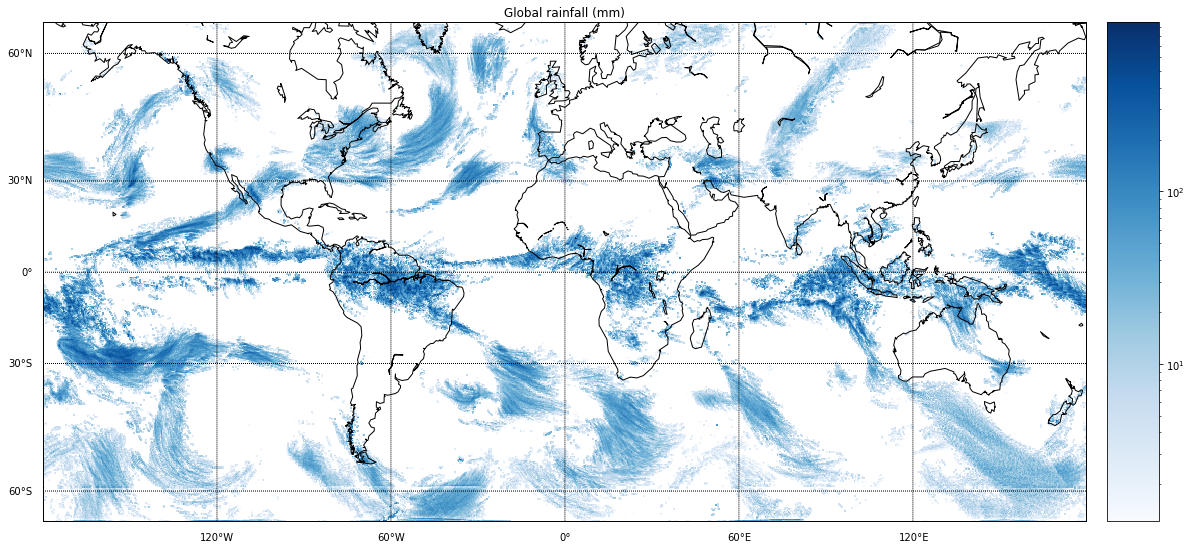

In [20]:
plt.figure(figsize=(20,20))

# Prepare a matplotlib Basemap so we can render coastlines and borders
m = Basemap(projection='merc',
  llcrnrlon=np.nanmin(lon_grid),urcrnrlon=np.nanmax(lon_grid),
  llcrnrlat=np.nanmin(lat_grid),urcrnrlat=np.nanmax(lat_grid),
  resolution='c')

# Convert lat/lon to a 2D grid
# lon_grid,lat_grid = np.meshgrid(lon,lat)
x,y = m(lon_grid,lat_grid)

# Clip our plot values to an upper threshold, and leave anything
# below the lower threshold as white (i.e., unplotted)
n_files = len(blob_urls)
upper_plot_threshold = n_files*10
lower_plot_threshold = n_files*0.01

Z = rainfall.copy()
Z[Z > upper_plot_threshold] = upper_plot_threshold
Z[Z < lower_plot_threshold] = np.nan
Z = np.ma.masked_where(np.isnan(Z),Z)

# Choose normalization and color mapping
norm = mpl.colors.LogNorm(vmin=Z.min(), vmax=Z.max(), clip=True)
cmap = plt.cm.Blues

# Plot as a color mesh
cs = m.pcolormesh(x,y,Z,norm=norm,cmap=cmap)

# Draw extra stuff to make our plot look fancier... sweeping clouds on a plain background
# are great, but sweeping clouds on contentinal outlines are *very* satisfying.
m.drawcoastlines()
m.drawmapboundary()
m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])
m.colorbar(cs)

plt.title('Global rainfall ({})'.format(rain_units))
plt.show()

### Clean up temporary files

In [21]:
shutil.rmtree(temp_dir)